In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls content drive

ls: cannot access 'content': No such file or directory
drive:
'My Drive'  'Shared drives'


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install glove_python

     |████████████████████████████████| 266kB 9.9MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=702592 sha256=bedafa1ca32717eb2392f1109bc8d06011c5192a98e676fd4cff21c8d90581fb
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


### 데이터 불러오기

In [0]:
youtube_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/small_total_train_set.csv")
youtube_data

,Unnamed: 0,Unnamed: 0.1,channel_name,subscribers,video_name,days_after_upload,video_duration,hits,likes_num,dislikes_num,category_id,thumbnail
0,0,0,복덩이,104000,"너무나맛있는 '알타리묵은지찜과' ""앞치마에그림"" Altari old paper st...",10,311,1126,40,1,0,https://i.ytimg.com/vi/al52wJgMGyI/hqdefault.j...
1,1,1,복덩이,104000,헌옷으로만든 [앞치마]와 '민들레' 겉절이 'Apron' made with old ...,11,416,1067,85,3,0,https://i.ytimg.com/vi/-xx7shznKec/hqdefault.j...
2,2,2,복덩이,104000,탈모와다이어트에 탁월한고급진 '느타리버섯볶음' 과 프로방스 창문그리기 Stir-fr...,12,265,860,64,0,0,https://i.ytimg.com/vi/m7KC7oEKKuo/hqdefault.j...
3,3,3,복덩이,104000,감기 면연력 간기능보호에 탁월한 '도라지튀김' '민들레튀김' '라벤다그리기' Fri...,13,419,1116,76,1,0,https://i.ytimg.com/vi/FYeuMGEgNWA/hqdefault.j...
4,4,4,복덩이,104000,진달래화전 부침 복덩이표 바삭바삭한 쫀득쫀득비법공개,14,287,622,47,2,0,https://i.ytimg.com/vi/UjLKW2fjkyA/hqdefault.j...
...,...,...,...,...,...,...,...,...,...,...,...,...
13680,31680,31680,키다리형,44000,[VLOG] 체지방 한자릿수 유지식단::뭐든지 과하면 독이다 :: 추억의 VLOG,424,601,47391,554,18,6,https://i.ytimg.com/vi/gPEWgwBoT6I/hqdefault.j...
13681,31681,31681,키다리형,44000,[키용소 2화] 그들의 입맛을 사로잡은 식단 대공개 (맛있게 다이어트하자),426,1146,52216,959,18,6,https://i.ytimg.com/vi/p7Ssy5gB_5A/hqdefault.j...
13682,31682,31682,키다리형,44000,[실속2분팁] 덤벨로우 tip (넓고 두꺼운 등을 위하여),427,142,118107,1300,29,6,https://i.ytimg.com/vi/PI7UN15-5K0/hqdefault.j...
13683,31683,31683,키다리형,44000,[키용소 1화] 살빼는방법을 모르겠어요 :: 위험한 계약,429,1282,78212,1600,42,6,https://i.ytimg.com/vi/iI4-fi64bss/hqdefault.j...


In [0]:
# data['subscribers'].value_counts()

In [0]:
# data[data['subscribers'] >= 200000000]

In [0]:
youtube_data = youtube_data[['video_name','category_id']]

In [0]:
print(youtube_data.isnull().values.any())

False


In [0]:
youtube_data['category_id'].value_counts()

5    3582
0    2040
6    2028
2    1897
4    1871
1    1777
3     490
Name: category_id, dtype: int64

### 텍스트 전처리

In [0]:
!pip install soynlp

#### 정규화

In [0]:
from soynlp.normalizer import *

In [0]:
for i in youtube_data.index:
  youtube_data['video_name'][i] = emoticon_normalize(youtube_data['video_name'][i],num_repeats=0)
  youtube_data['video_name'][i] = repeat_normalize(youtube_data['video_name'][i],num_repeats=0)
  youtube_data['video_name'][i] = only_hangle(youtube_data['video_name'][i])

In [0]:
youtube_data

In [0]:
titles = list(youtube_data.video_name)
id_num = list(youtube_data.category_id)

#### Stopwords

In [0]:
s_file_name = open('/content/drive/My Drive/Colab Notebooks/ko/stopwords.txt','r',encoding='utf-8')

In [0]:
stop_words = []
for line in s_file_name.readlines():
  stop_words.append(line.rstrip())
s_file_name.close()

In [0]:
print(len(stop_words))

#### Tokenize

In [0]:
from soynlp.word import WordExtractor

word_extractor = WordExtractor()
word_extractor.train(titles)
word_score = word_extractor.extract()

In [0]:
from soynlp.tokenizer import MaxScoreTokenizer
word_scores = {word:score.cohesion_forward for word, score in word_score.items()}
word_tokenizer = MaxScoreTokenizer(scores=word_scores)

word_token = []
for sentence in titles:
    temp_X = word_tokenizer.tokenize(sentence, flatten=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    word_token.append(temp_X)

In [0]:
print(len(titles))
print(len(word_token))

In [0]:
word_token[:3]

In [0]:
for i in range(len(word_token)):
  try:
    if len(word_token[i]) == 0:
      del titles[i]
      del word_token[i]
      del id_num[i]
  except IndexError:
    pass

In [0]:
nan_list = []
for i in range(len(word_token)):
  if len(word_token[i]) == 0:
      nan_list.append(i)

In [0]:
nan_list

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
word_vocab = Tokenizer()
word_vocab.fit_on_texts(word_token)

In [0]:
print(len(word_vocab.word_index))
print(word_vocab.word_index)

In [0]:
threshold = 3
total_cnt = len(word_vocab.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_vocab.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [0]:
vocab_size = total_cnt - rare_cnt # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

In [0]:
words_frequency = [w for w,c in word_vocab.word_counts.items() if c < 3]
# 빈도수가 3미만인 단어를 w라고 저장
for w in words_frequency:
    del word_vocab.word_index[w]
    del word_vocab.word_counts[w]

In [0]:
vocab_list = list(word_vocab.word_index.keys())

In [0]:
print(len(vocab_list))

In [0]:
final_token = []
for sentence in titles:
    temp_X = word_tokenizer.tokenize(sentence, flatten=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
    temp_X = [word for word in temp_X if word in vocab_list]
    final_token.append(temp_X)

In [0]:
len(final_token)

In [0]:
for i in range(len(final_token)):
  try:
    if len(final_token[i]) == 0:
      del titles[i]
      del final_token[i]
      del id_num[i]
  except IndexError:
    pass

In [0]:
nan_list = []
for i in range(len(final_token)):
  if len(final_token[i]) == 0:
      nan_list.append(i)

In [0]:
nan_list

#### 임베딩

In [0]:
from gensim.models import Word2Vec
w2v = Word2Vec(sentences = final_token, size = 100, window = 4, min_count = 1, workers = 4,sample=1e-3, iter=5, sg = 1)

In [0]:
from gensim.models import FastText
fxt = FastText(sentences = final_token, size = 100, window = 4, min_count = 1, workers = 4,sample=1e-3, iter=5, sg = 1)

In [0]:
glv_sequences = word_vocab.texts_to_sequences(final_token)
glv_text = word_vocab.sequences_to_texts(glv_sequences)

In [0]:
glove_token = []
for i in range(len(glv_text)):
  glove_token.append(glv_text[i].split())

In [0]:
from glove import Corpus, Glove

corpus = Corpus() 
corpus.fit(glove_token, window=4)
# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성

glv = Glove(no_components=100, learning_rate=0.05)
glv.fit(corpus.matrix, epochs=30, no_threads=3, verbose=False)
glv.add_dictionary(corpus.dictionary)

In [0]:
print(w2v.wv.vectors.shape)
print(fxt.wv.vectors.shape)
print(glv.word_vectors.shape)

In [0]:
len(glv.dictionary.keys()) == len(w2v.wv.index2word)

### 문장의 단어 벡터 평균값으로 특성 구하기

In [0]:
def get_features(words, model, num_features):
    # 출력 벡터 초기화
    feature_vector = np.zeros((num_features), dtype=np.float32)
    
    num_words = 0
    # 어휘 사전 준비
    index2word_set = set(model.wv.index2word)
    
    for w in words:
        if w in index2word_set:
            num_words = 1
            # 사전에 해당하는 단어에 대해 단어 벡터를 더함
            feature_vector = np.add(feature_vector, model[w])
            
    # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
    feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

In [0]:
def get_dataset(reviews, model, num_features):
    dataset = list()
    
    for s in reviews:
        dataset.append(get_features(s, model, num_features))
        
    reviewFeatureVecs = np.stack(dataset)
    return reviewFeatureVecs

In [0]:
data_w2v = get_dataset(final_token,w2v,100)

In [0]:
data_fxt = get_dataset(final_token,fxt,100)

#### 테스트

In [0]:
from sklearn.model_selection import train_test_split

X = data_w2v
y = np.array(id_num)

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, 
                                                    random_state=RANDOM_SEED)

In [0]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

In [0]:
predicted = lgs.predict(X_test)

print("Accuracy: %f" % lgs.score(X_test, y_test))  #checking the accuracy

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train,y_train)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
accuracy_score(y_test,y_pred)

### 내적으로 특성 구하기

##### DTM만들기

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
cv = CountVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,vocabulary=vocab_list)

In [0]:
tdm = cv.fit_transform(titles).toarray()

In [0]:
print(len(cv.get_feature_names()))

In [0]:
print(tdm.shape)

In [0]:
tdm

##### 가중치 행렬 구하기

In [0]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(w2v.wv.vectors, w2v.wv.vectors)
wght_w2v = np.exp(-(distance_matrix ** 2) / (2 * np.var(distance_matrix)))

In [0]:
distance_matrix = euclidean_distances(fxt.wv.vectors,fxt.wv.vectors)
wght_fxt = np.exp(-(distance_matrix ** 2) / (2 * np.var(distance_matrix)))

In [0]:
distance_matrix = euclidean_distances(glv.word_vectors, glv.word_vectors)
wght_glv = np.exp(-(distance_matrix ** 2) / (2 * np.var(distance_matrix)))

In [0]:
print(wght_w2v.shape)
print(wght_fxt.shape)
print(wght_glv.shape)

##### 내적

In [0]:
feat_w2v = np.dot(tdm,wght_w2v)

In [0]:
feat_fxt = np.dot(tdm,wght_fxt)

In [0]:
feat_glv = np.dot(tdm,wght_glv)

In [0]:
print(feat_w2v.shape)
print(feat_fxt.shape)
print(feat_glv.shape)

In [0]:
def slower_dot (A, B):
    """Low-memory implementation of dot product"""
    #Assuming A and B are of the right type and size
    R = np.empty([A.shape[0], B.shape[1]])
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            R[i,j] = np.dot(A[i,:], B[:,j])
    return R

In [0]:
#R[0,1] = np.array(np.dot(tdm_32[1,:],weight_matrix_w2v[:,1]))

In [0]:
#dotproduct_test = slower_dot(tdm_test_32,test_wght_w2v)

In [0]:
#dotproduct_test.shape

In [0]:
dot_w2v = np.dot(tdm,w2v.wv.vectors)

In [0]:
dot_fxt = np.dot(tdm,fxt.wv.vectors)

In [0]:
dot_glv = np.dot(tdm,glv.word_vectors)

In [0]:
print(dot_w2v.shape)
print(dot_fxt.shape)
print(dot_glv.shape)

In [0]:
for i in range(len(dot_w2v)):
  dot_w2v[i] = dot_w2v[i]/len(dot_w2v[i])

In [0]:
dot_w2v.shape

##### 테스트

In [0]:
from sklearn.model_selection import train_test_split

X = feat_w2v
y = np.array(id_num)

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, 
                                                    random_state=RANDOM_SEED)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score #정확도 계산

In [0]:
mod = MultinomialNB()
mod.fit(X_train,y_train)

In [0]:
predicted = mod.predict(X_test) #테스트 데이터에 대한 예측

In [0]:
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

In [0]:
from sklearn.model_selection import train_test_split

X = dot_w2v
y = np.array(id_num)

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, 
                                                    random_state=RANDOM_SEED)

In [0]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

In [0]:
predicted = lgs.predict(X_test)

print("Accuracy: %f" % lgs.score(X_test, y_test))  #checking the accuracy

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train,y_train)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
accuracy_score(y_test,y_pred)

### 단어 임베딩 레이어로 활용하기

#### padding

In [0]:
from sklearn.model_selection import train_test_split

X = titles
y = np.array(id_num)

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, 
                                                    random_state=RANDOM_SEED)

In [0]:
lstm_tok = Tokenizer(vocab_size) 
lstm_tok.fit_on_texts(word_token)
X_train = lstm_tok.texts_to_sequences(X_train)
X_test = lstm_tok.texts_to_sequences(X_test)

In [0]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

10868
10868
2718
2718


In [0]:
#drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
#drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [0]:
# 빈 샘플들을 제거
#X_train = np.delete(X_train, drop_train, axis=0)
#y_train = np.delete(y_train, drop_train, axis=0)


In [0]:
# 빈 샘플들을 제거
#X_test = np.delete(X_test, drop_test, axis=0)
#y_test = np.delete(y_test, drop_test, axis=0)

In [0]:
print('제목의 최대 길이 :',max(len(l) for l in X_train))

제목의 최대 길이 : 16


In [0]:
X_train = pad_sequences(X_train, maxlen = 16)
X_test = pad_sequences(X_test, maxlen = 16)

In [0]:
y_train = to_categorical(y_train) # 훈련용 레이블  원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 레이블 원-핫 인코딩

In [0]:
X_train

array([[   0,    0,    0, ...,  680,   43,  109],
       [   0,    0,    0, ...,    0,    0,    8],
       [   0,    0,    0, ...,  495, 4223,   26],
       ...,
       [   0,    0,    0, ...,    0,    0, 1308],
       [   0,    0,    0, ..., 1456,  964, 2664],
       [   0,    0,    0, ...,  480, 1673,    1]], dtype=int32)

In [0]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

#### LSTM

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [0]:
model_mw = Sequential()
model_mw.add(Embedding(vocab_size, 30))
model_mw.add(LSTM(30))
model_mw.add(Dense(7, activation='softmax'))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
model_mw.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
history_mw = model_mw.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
143/145 [============================>.] - ETA: 0s - loss: 1.7308 - acc: 0.3178
Epoch 00001: val_acc improved from -inf to 0.44112, saving model to best_model.h5
145/145 [==============================] - 2s 14ms/step - loss: 1.7301 - acc: 0.3187 - val_loss: 1.5240 - val_acc: 0.4411
Epoch 2/15
144/145 [============================>.] - ETA: 0s - loss: 1.3222 - acc: 0.5318
Epoch 00002: val_acc improved from 0.44112 to 0.62098, saving model to best_model.h5
145/145 [==============================] - 2s 11ms/step - loss: 1.3210 - acc: 0.5328 - val_loss: 1.1790 - val_acc: 0.6210
Epoch 3/15
145/145 [==============================] - ETA: 0s - loss: 1.0126 - acc: 0.6848
Epoch 00003: val_acc improved from 0.62098 to 0.67847, saving model to best_model.h5
145/145 [==============================] - 2s 11ms/step - loss: 1.0126 - acc: 0.6848 - val_loss: 0.9648 - val_acc: 0.6785
Epoch 4/15
144/145 [============================>.] - ETA: 0s - loss: 0.7860 - acc: 0.7541
Epoch 00004: val_a

In [0]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

85/85 [==============================] - 0s 3ms/step - loss: 0.6681 - acc: 0.7837

 테스트 정확도: 0.7837


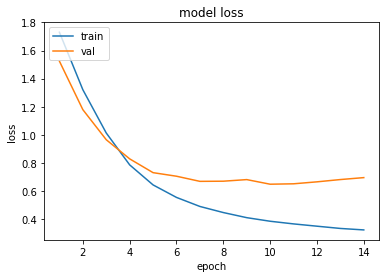

In [0]:
epochs = range(1, len(history_mw.history['acc']) + 1)
plt.plot(epochs, history_mw.history['loss'])
plt.plot(epochs, history_mw.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
glv_word = list(glv.dictionary.keys())

In [0]:
glv_word[0]

'너무'

In [0]:
glv_array[0]

array([-0.00295822, -0.02126132,  0.00195257,  0.02797044, -0.00412266,
       -0.00783026, -0.01306685, -0.02123635,  0.02649702,  0.03491552,
       -0.0172662 ,  0.01456639, -0.03357163, -0.02732099,  0.02396705,
       -0.00124373,  0.01383804,  0.00105802, -0.03935583, -0.01471795,
        0.03296948,  0.02876232,  0.05032196,  0.01112716, -0.03786947,
        0.03787678,  0.01042273, -0.00102044,  0.01886321,  0.01441982,
       -0.0275732 ,  0.02576511,  0.00762652,  0.01484478, -0.01141577,
        0.04320553,  0.01352679, -0.03456509, -0.01146146,  0.01134498,
        0.01671483, -0.01136908, -0.0353498 , -0.01991002,  0.02268381,
        0.04247952,  0.02222515,  0.02768546,  0.01809215, -0.02363227,
       -0.0338142 ,  0.0029322 ,  0.03784269, -0.00456   , -0.02264334,
       -0.02494194, -0.02954115, -0.01254952, -0.01587731, -0.00301173,
       -0.03205265,  0.01620253,  0.01224273,  0.00084087,  0.04195974,
       -0.00660936, -0.02020211,  0.01273052,  0.02775607, -0.01

In [0]:
glv_array = glv.word_vectors

In [0]:
embedding_dict = dict()
for i in range(len(glv_word)):
  embedding_dict[glv_word[i]] = glv_array[i]

In [0]:
len(embedding_dict)

6047

In [0]:
vocab_size

6047

In [0]:
embedding_matrix = np.zeros((vocab_size,100))
np.shape(embedding_matrix)

(6047, 100)

In [0]:
lstm_tok.word_index.items()

dict_items([('고양이', 1), ('맛있', 2), ('은', 3), ('미국', 4), ('문재인', 5), ('한국', 6), ('만들기', 7), ('레시피', 8), ('오버워치', 9), ('다', 10), ('증시', 11), ('중국', 12), ('국민', 13), ('축구', 14), ('게임', 15), ('도', 16), ('북한', 17), ('대', 18), ('고', 19), ('만', 20), ('야구', 21), ('부', 22), ('이유', 23), ('방법', 24), ('트럼프', 25), ('법', 26), ('코로나', 27), ('조국', 28), ('ㅣ부동산읽어주는남자', 29), ('황교안', 30), ('없는', 31), ('들어', 32), ('세계', 33), ('경제', 34), ('운동', 35), ('투자', 36), ('강아지', 37), ('정권', 38), ('선수', 39), ('볶음', 40), ('있는', 41), ('대표', 42), ('글로벌', 43), ('만드는', 44), ('공개', 45), ('정치', 46), ('김정은', 47), ('할', 48), ('프로', 49), ('면', 50), ('하면', 51), ('요리', 52), ('총선', 53), ('ㅣ', 54), ('반응', 55), ('만드는법', 56), ('영상', 57), ('아기', 58), ('좋은', 59), ('진짜', 60), ('대한민국', 61), ('시장', 62), ('영화', 63), ('해', 64), ('기자들의', 65), ('위기', 66), ('스톡체크', 67), ('청와대', 68), ('일본', 69), ('분석', 70), ('주식경제', 71), ('보고', 72), ('보는', 73), ('하이라이트', 74), ('화', 75), ('주식', 76), ('너무', 77), ('쉽고', 78), ('인', 79), ('정부', 80), ('경기', 81), ('주의

In [0]:
for word, i in lstm_tok.word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    temp = embedding_dict.get(word) # 단어(key) 해당되는 임베딩 벡터의 100개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix[i] = temp # 임수 변수의 값을 단어와 맵핑되는 인덱스의 행에 삽입

IndexError: ignored

In [0]:
model_mw = Sequential()
model_mw.add(Embedding(vocab_size, 30))
model_mw.add(LSTM(30))
model_mw.add(Dense(7, activation='softmax'))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
model_mw.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
history_mw = model_mw.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

In [0]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

85/85 [==============================] - 0s 3ms/step - loss: 0.6681 - acc: 0.7837

 테스트 정확도: 0.7837


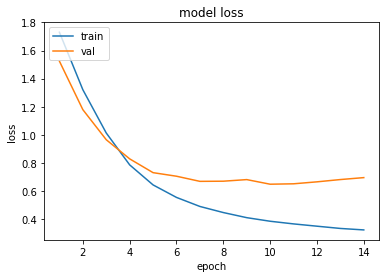

In [0]:
epochs = range(1, len(history_mw.history['acc']) + 1)
plt.plot(epochs, history_mw.history['loss'])
plt.plot(epochs, history_mw.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### CNN

In [0]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


In [0]:
import tensorflow as tf
import numpy as np


class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(3, pooled_outputs)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # CalculateMean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [0]:
TextCNN(X_train,y_train,vocab_size=vocab_size,embedding_size=100,filter_sizes=2,num_filters=1)

AttributeError: ignored

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h1', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
history_cnn = model_cnn.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)